In [3]:

def RemovePunc(comment):
    comment = comment.replace('^\d+|\n|\t|"|==|;|:|@', '')
    comment = comment.replace('\d+', '')
    comment = comment.replace(',', '')
    comment = comment.replace('?', '')
    comment= comment.replace('!', '')
    comment = comment.replace('&', '')
    comment = comment.replace('[...]', '')
    comment = comment.replace('[....]', '')
    for c in string.punctuation:
        comment = comment.replace(c, "")
    return (comment)

def RemoveHttp(comment):
    comment = re.sub(r'(((https|http)?://)|(www.))(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F])|#)',
                     '', comment, flags=re.MULTILINE)
    return (comment)

def ConvertToLowerCase(comment):
    comment = comment.lower()
    return(comment)

def StemComment(comment,lowerCase,punc,http):
    if lowerCase:
        comment = ConvertToLowerCase(comment)
    if punc:
        comment = RemovePunc(comment)
    if http:
        comment = RemoveHttp(comment)
        
    comment=''.join([i for i in comment if not i.isdigit()])
    comment = nlp(comment)
    lemmatized = []
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            lemmatized.append(lemma)
    return " ".join(lemmatized)
    
def dataStem(Data,lowerCase,punc,http):
    Data_lemmatized = Data.apply(StemComment, lowerCase=True,punc=True,http=True)
    return Data_lemmatized

def saveInFile(x_train_lemmatized,fileName):
    filehandler = open(fileName+".p", "wb")
    pickle.dump(x_train_lemmatized, filehandler)
    filehandler.close()
    
def loadFromFile(fileName):
    file = open(fileName+".p", 'rb')
    object_file = pickle.load(file)
    file.close()
    return object_file

def sampling(data):
    clean = data.loc[np.random.choice(data[data['clean']==True].index.tolist(),size=9237)].reset_index(drop=True)
    severe_toxic = data.loc[np.random.choice(data[data['severe_toxic']==True].index.tolist(),size=6000,replace=True)].reset_index(drop=True)
    obscene = data.loc[np.random.choice(data[data['obscene']==True].index.tolist(),size=2000,replace=True)].reset_index(drop=True)
    threat = data.loc[np.random.choice(data[data['threat']==True].index.tolist(),size=6000,replace=True)].reset_index(drop=True)
    insult = data.loc[np.random.choice(data[data['insult']==True].index.tolist(),size=2300,replace=True)].reset_index(drop=True)
    identity_hate = data.loc[np.random.choice(data[data['identity_hate']==True].index.tolist(),size=6000,replace=True)].reset_index(drop=True)
    toxic = data[data['toxic']==1].reset_index(drop=True)

    sampled_train = pd.concat([clean,threat,toxic,severe_toxic,insult,identity_hate,obscene]).reset_index(drop=True)
    sampled_train = sampled_train.sample(frac=1).reset_index(drop=True)
    sampled_train['clean'] = sampled_train['clean'].astype(int)
    return sampled_train

def Translate(data):
    translator = Translator()
    translations= translator.translate(data)
    return translations.text

def TranslateTheDataSet(data):
    for index, row in data.iterrows():
        rowString=row['comment_text']
        if(len(rowString)>5000):
            rowString=row['comment_text'][:5000]
        try:
            translate = Translator()
            lang = translate.detect(rowString).lang
        except ValueError:
            continue
        if (lang != 'en'):
            try:
                transComment = Translate(rowString)
                data.at[index, 'comment_text'] = transComment
            except ValueError:
                continue
    return data



# Apply Stemming on Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import pickle
import re
import spacy
import en_core_web_sm


#nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])
nlp = en_core_web_sm.load()

train = pd.read_csv('New_Data\\train.csv')
test = pd.read_csv('New_Data\\test.csv')
#print(train)
train.index = train['id']
x_train = train['comment_text']
y_train = train.iloc[:, 2:]
test.index = test['id']
x_test = test['comment_text']
y_train['clean'] = 1 - y_train.sum(axis=1) >= 1
x_train2 = x_train.dropna()
x_test2 = x_test.dropna()
print('start train lemmatize')
x_train_lemmatized=dataStem(x_train2,lowerCase=True,punc=True,http=True)
print(x_train_lemmatized)
print('start test lemmatize')
x_test_lemmatized=dataStem(x_test2,lowerCase=True,punc=True,http=True)
train2=pd.concat([x_train_lemmatized,y_train], axis=1)

saveInFile(train2,'train')#_TestwithPunc')
saveInFile(x_test_lemmatized,'test')#_TestwithPunc')
print('Lemmatizing and storing done!')

start train lemmatize
id
0000997932d777bf    explanation why the edit make under -PRON- use...
000103f0d9cfb60f    daww -PRON- match this background colour -PRON...
000113f07ec002fd    hey man -PRON- be really not try to edit war -...
0001b41b1c6bb37e    much i can not make any real suggestion on imp...
0001d958c54c6e35    -PRON- sir be -PRON- hero any chance -PRON- re...
00025465d4725e87    congratulation from -PRON- a good use the tool...
0002bcb3da6cb337    cocksucker before -PRON- piss around on -PRON-...
00031b1e95af7921    -PRON- vandalism to the matt shirvington artic...
00037261f536c51d    sorry if the word nonsense be offensive to -PR...
00040093b2687caa    alignment on this subject and which be contrar...
0005300084f90edc    fair use rationale for imagewonjujpg thank for...
00054a5e18b50dd4    bbq be a man and let discuss itmaybe over the ...
0005c987bdfc9d4b    hey what be -PRON- talk what be -PRON- a exclu...
0006f16e4e9f292e    before -PRON- start throw accusation and warn

# NB with 50,000 features

In [5]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

train = pickle.load(open('train_Test.p','rb'))
test = pickle.load(open('test_Test.p','rb'))
sample = pd.read_csv('sample_submission.csv')
sampled_train=sampling(train)
feature_model = TfidfVectorizer(ngram_range=(1, 4),max_features=50000)
feature_matrix = feature_model.fit_transform(sampled_train['comment_text'])
print(feature_matrix)
test_x = feature_model.transform(test)
for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    clf = MultinomialNB()
    clf.fit(feature_matrix, sampled_train[col])
    preds = clf.predict_proba(test_x)[:, 1]
    print(col)
    print(preds)
    print(sample.shape, preds.shape)
    sample[col] = preds

sample.to_csv("result0.csv", index=False)


  (0, 1229)	0.55131507112
  (0, 0)	0.574329711413
  (0, 1230)	0.605142193988
  (5, 323)	1.0
  (9, 1229)	0.240746532825
  (9, 0)	0.250796493629
  (9, 1230)	0.264251591695
  (9, 1603)	0.408279174097
  (9, 1662)	0.544562723742
  (9, 1663)	0.588279591616
  (11, 1229)	0.341705443511
  (11, 2081)	0.607290051835
  (11, 1476)	0.7172420671
  (12, 1229)	0.55131507112
  (12, 0)	0.574329711413
  (12, 1230)	0.605142193988
  (13, 1229)	0.289016653109
  (13, 655)	0.479528465636
  (13, 1349)	0.483706737631
  (13, 730)	0.304910194502
  (13, 1367)	0.306103014153
  (13, 747)	0.364451867013
  (13, 1370)	0.364767284013
  (14, 1945)	1.0
  (15, 0)	0.190437282332
  :	:
  (46814, 1229)	0.55131507112
  (46814, 0)	0.574329711413
  (46814, 1230)	0.605142193988
  (46819, 1603)	1.0
  (46822, 1229)	0.55131507112
  (46822, 0)	0.574329711413
  (46822, 1230)	0.605142193988
  (46824, 1603)	0.412188064285
  (46824, 501)	0.263081085598
  (46824, 852)	0.230207141681
  (46824, 505)	0.263155153688
  (46824, 1075)	0.543299271

# Title

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import nltk
import sklearn as sk
import pickle
log_lossTFIDF = np.zeros(shape=(11,7))
i=0
train = pickle.load(open('train_Test.p','rb'))
test = pickle.load(open('test_Test.p','rb'))
sampled_train=sampling(train)
for mx_W in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    j=0
    #sample_tfidf = pd.read_csv('sample_submission.csv')
    #sample_count = pd.read_csv('sample_submission.csv')
    for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','clean']:
        x_fit,x_valid,y_fit,y_valid = train_test_split(sampled_train['comment_text'],sampled_train[col],test_size=.5,random_state=46)
        #     feature_model = TfidfVectorizer(ngram_range=(1,4))
        #     x_fit = feature_model.fit_transform(x_fit)
        #     x_valid = feature_model.transform(x_valid)

        feature_model_tfidf = TfidfVectorizer(ngram_range=(1, 4), max_features=50000)
        feature_matrix_tfidf = feature_model_tfidf.fit_transform(x_fit)
        test_x = feature_model_tfidf.transform(x_valid)

        clf = LogisticRegression(C=1) 
        clf.fit(feature_matrix_tfidf, y_fit)
        predsLR = clf.predict_proba(test_x)[:, 1]
        predsLR = predsLR*mx_W
#        preds = np.insert(preds, 52300, 0.5)
        print(col, mx_W)
        # print(preds)
        # print(sample.shape,preds.shape)
        # print(classification_report(y_valid,preds))
        #sample_tfidf[col] = preds
     #   log_lossTFIDF[i,j]=log_loss(y_valid, predsTFIDF)


        ##############################################

        #feature_model_count = CountVectorizer(ngram_range=(1, 4), max_features=mx_feat)
        #feature_matrix_count = feature_model_count.fit_transform(x_fit)
        #test_x = feature_model_count.transform(x_valid)

        clf = SVC(probability=True,C=1,kernel='linear')
        clf.fit(feature_matrix_tfidf, y_fit)
        predsSVM = clf.predict_proba(test_x)[:, 1]
        predsSVM=predsSVM*(1-mx_W)
       # preds = np.insert(preds, 52300, 0.5)
        preds=predsLR+predsSVM
        log_lossTFIDF[i,j]=log_loss(y_valid, preds)
        j=j+1
        print(col, mx_W)
    i=i+1

toxic 0
toxic 0
severe_toxic 0
severe_toxic 0
obscene 0
obscene 0
threat 0
threat 0
insult 0
insult 0
identity_hate 0
identity_hate 0
clean 0
clean 0
toxic 0.1
toxic 0.1
severe_toxic 0.1
severe_toxic 0.1
obscene 0.1


KeyboardInterrupt: 

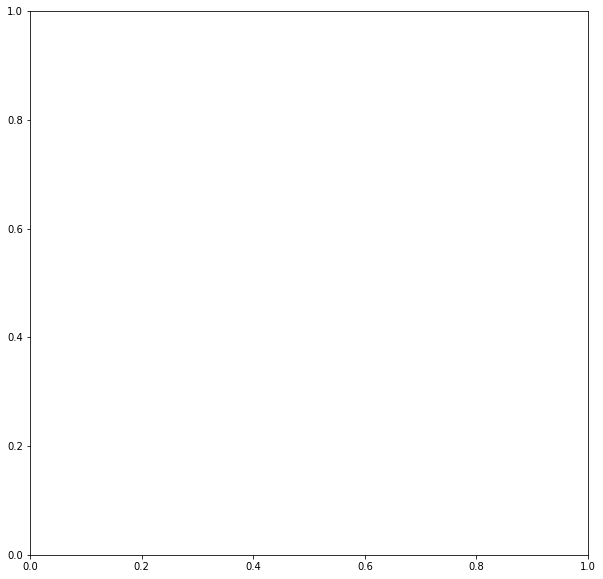

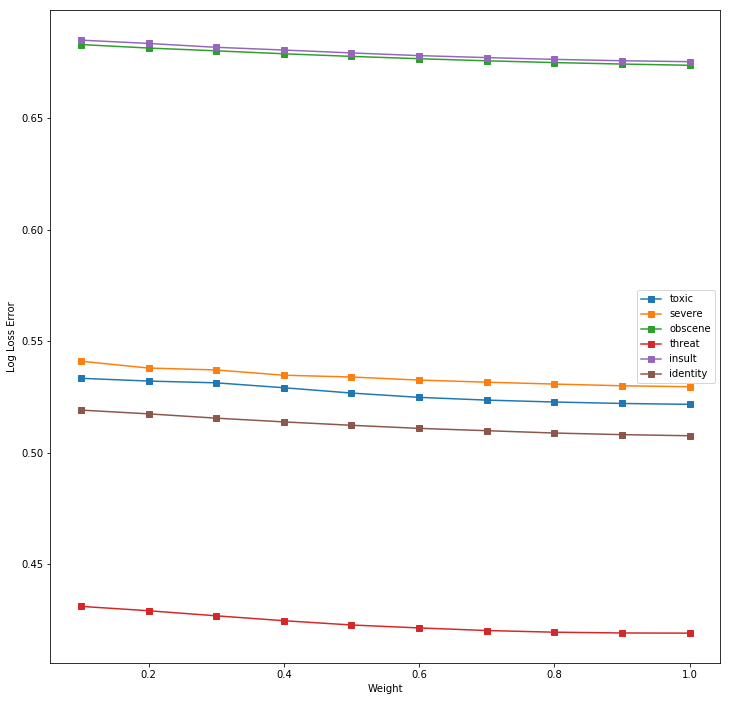

[ 0.565386    0.56355582  0.56207863  0.56025271  0.55873147  0.55735614
  0.55632068  0.55547     0.55484466  0.55444826]


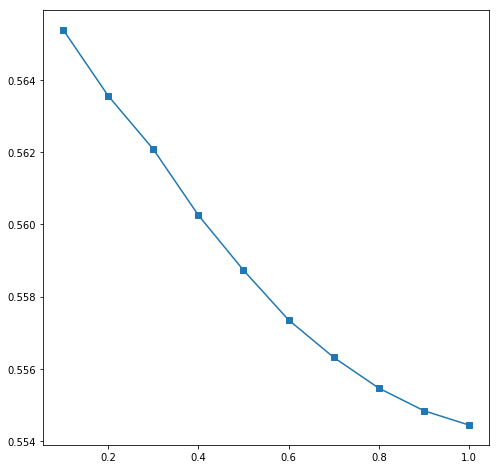

In [12]:
TfIDF3 = np.array(log_lossTFIDF)
plt.figure(figsize=(12,12))
plt.xlabel('Weight')
plt.ylabel('Log Loss Error')
cols = ['toxic','severe','obscene','threat','insult','identity']
for ii in range(6):
    plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],TfIDF3[:,ii],'-s',label=cols[ii])
plt.legend()
plt.show()

print(np.mean(TfIDF3,axis=1))
plt.figure(figsize=(8,8))
plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], np.mean(TfIDF3,axis=1),'-s')
plt.show()